<a href="https://colab.research.google.com/github/ffabi/AssettoCorsaSelfDriving/blob/master/AssettoCorsaSelfDriving_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, BatchNormalization, pooling, MaxPooling2D, PReLU
#SwishBeta
from keras.layers import Layer, initializers, InputSpec
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam, SGD, Nadam
import PIL
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, TensorBoard
import sys
import seaborn as sns 
from keras.preprocessing.image import img_to_array, load_img
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
# np.set_printoptions(threshold=np.nan)
np.set_printoptions(threshold=20)
np.random.seed(1234)
set_random_seed(1234)

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

#change working directory to google drive
import os
os.chdir("/content/gdrive/My Drive/AssettoCorsaSelfDriving")

#enable importing python modules from the folder 'modules'
# sys.path.append('modules')

img_shape = (73, 200, 3)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Prepare dataset

In [0]:
from PIL import Image

class LapRecognition:
    def __init__(self, threshold = 100):
        self.s1 = slice(134, 166)
        self.s2 = slice(1192, 1222)
        self.threshold = threshold
        
        self.number_one = img_to_array(load_img("modules/number_one.png"))
        
        
    def mse(self, imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err
    

    def is_lap_one(self, image):
        difference = self.mse(image[self.s1, self.s2], self.number_one)
        return difference < self.threshold

In [0]:
import os, cv2
import PIL

class DataPreparation:
    def __init__(self, width, height) -> None:
        super().__init__()
       
        self.amount_of_frames = 0
        self.amount_of_demo_frames = 0
        self.rec = LapRecognition(threshold=100)
        
        self.img_shape = (height, width, 3)
        

    def prepare(self, verbose = False):
        
        output = os.popen("ls dataset/videos | wc -l").read()
        amount_of_videos = int(output.replace("\n", ""))
        
        output = os.popen("ls dataset/metainfos | wc -l").read()
        amount_of_metafiles = int(output.replace("\n", ""))
        
        if verbose:
            print("Found", amount_of_videos, "videofiles and", amount_of_metafiles, "metafiles")
        
        amount_of_videos = min(amount_of_videos, amount_of_metafiles)
        
        datapoints = []
                
        for i in range(1, amount_of_videos+1):
            cap = cv2.VideoCapture("dataset/videos/" + str(i) + ".mp4")
            metafile = open("dataset/metainfos/"+ str(i) + ".txt")
            ret, frame = cap.read()
            
            videolength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            #read videofile until the start of the lap
            counter=0
            while not self.rec.is_lap_one(frame):
                ret, frame = cap.read()
                counter += 1
            if verbose:
                print("Found first frame of the first lap at", counter)
            
            videolength -= counter
            #reading while the first lap is recorded
            counter = 0
            while self.rec.is_lap_one(frame) and ret:
                values = metafile.readline().split(";")
                if len(values) < 2:
                    break
                
                datapoints.append((float(values[0]), self.amount_of_frames))

                img = cv2.resize(frame[250:], (self.img_shape[1], self.img_shape[0]))
                cv2.imwrite("dataset/resized_frames/frame_" + str(self.amount_of_frames) + ".png", img)
                self.amount_of_frames += 1

                if verbose:
                    cnt = int(counter/videolength*50)
                    sys.stdout.write('\r'+ "Processing " + str(i) + "/" + str(amount_of_videos) + " video: [" + "="*cnt + ">" + " "*(50-cnt-1) + "]")
                
                counter += 1
            
                ret, frame = cap.read()
            
            metafile.close()
            
            print("")
                
        return np.array(datapoints, dtype=[('data', np.float32, 1), ('frame', np.int16, 1)])
    
    #name should be "demo.mp4"
    def prepare_demo(self, verbose = False):
        
        cap = cv2.VideoCapture("dataset/videos/demo.mp4")
        ret, frame = cap.read()

        videolength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        #read videofile until the start of the lap
        counter=0
        while not self.rec.is_lap_one(frame):
            ret, frame = cap.read()
            counter += 1
            
        if verbose:
            print("Found first frame of the first lap at", counter)

        videolength -= counter
        #reading while the first lap is recorded
        counter = 0
        while self.rec.is_lap_one(frame) and ret:

            img = cv2.resize(frame[250:], (self.img_shape[1], self.img_shape[0]))
            cv2.imwrite("dataset/demo_frames/frame_" + str(self.amount_of_demo_frames) + ".png", img)
            self.amount_of_demo_frames += 1

            if verbose:
                cnt = int(counter/videolength*50)
                sys.stdout.write('\r'+ "Processing demo video: [" + "="*cnt + ">" + " "*(50-cnt-1) + "]")

            counter += 1

            ret, frame = cap.read()



In [0]:
prep = DataPreparation(img_shape[1], img_shape[0])

In [0]:
# dataset = prep.prepare(True)

Found 3 videofiles and 3 metafiles
Found first frame of the first lap at 223
Processing 1/3 video: [=================================================>]
Found first frame of the first lap at 173
Processing 2/3 video: [=================================================>]
Found first frame of the first lap at 38
Processing 3/3 video: [=================================================>]


In [0]:
prep.prepare_demo(True)

Found first frame of the first lap at 140
Processing demo video: [=================================================>]

In [0]:
!ls -lfh dataset/resized_frames/* | grep " 0 "

ls: cannot access 'dataset/resized_frames/*': No such file or directory


In [0]:
!cp dataset/saved_resized_frames/frame_9561.png dataset/resized_frames/

In [0]:
np.save("dataset/serialized/dataset.npy", dataset)
!ls -lh dataset/serialized/dataset.npy

Size of dataset: 10587
Example data: (0.44150218, 0)


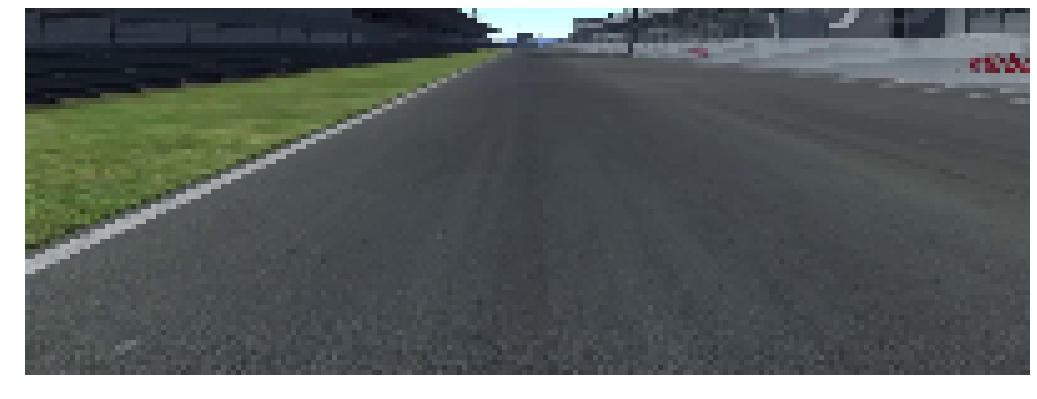

In [0]:
dataset = np.load("dataset/serialized/dataset.npy")

print("Size of dataset:", len(dataset))
print("Example data:", dataset[0])

img = Image.open("dataset/resized_frames/frame_" + str(dataset[0][1]) + ".png")
fig=plt.figure(figsize=(18, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

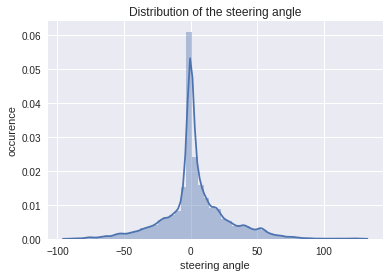

In [0]:
ax = sns.distplot(dataset["data"]);
ax.set(xlabel="steering angle", ylabel="occurence", title="Distribution of the steering angle")
plt.show()

#Train

In [58]:
dataset = np.load("dataset/serialized/dataset.npy")
np.random.shuffle(dataset)

valid_split = 0.2
test_split = 0.1
framecounter = len(dataset)

train = dataset[0:int(framecounter*(1-valid_split-test_split))]
valid = dataset[int(framecounter*(1-valid_split-test_split)):int(framecounter*(1-test_split))]
test  = dataset[int(framecounter*(1-test_split)):]

print("Number of train samples: ", len(train))
print("Example train data before minmax scaling:", train[0])
train_scale = train["data"].reshape(-1, 1)
valid_scale = valid["data"].reshape(-1, 1)
test_scale = test["data"].reshape(-1, 1)

#standard scaler
scaler = preprocessing.MinMaxScaler().fit(train_scale)
train["data"] = scaler.transform(train_scale).reshape(1, -1)
valid["data"] = scaler.transform(valid_scale).reshape(1, -1)
test["data"] = scaler.transform(test_scale).reshape(1, -1)

print("Example train data after minmax scaling:", train[0])

Number of train samples:  7410
Example train data before minmax scaling: (-4.3345447, 1509)
Example train data after minmax scaling: (0.3928333, 1509)


In [0]:
#@title DataGenerator { form-width: "20%", display-mode: "form" }
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, dataset, dim, batch_size=10, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        ids = [self.dataset["frame"][k] for k in indexes]
        datapoints = [self.dataset["data"][k] for k in indexes]

        """Generates data containing batch_size samples"""
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim), dtype=float)
        Y = np.empty((self.batch_size, *(1, )), dtype=float)
        # Generate data
        for i, ID in enumerate(ids):
            img = img_to_array(load_img('dataset/resized_frames/frame_' + str(ID) + '.png')) /255.0

            X[i,] = img
            Y[i,] = datapoints[i]

        return X, Y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)


##Swish activations

In [0]:
#@title Swish { form-width: "20%", display-mode: "form" }

class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    A = (K.sigmoid(x) * x)
    return A

get_custom_objects().update({'swish': Swish(swish)})

In [0]:
#@title SwishBeta { form-width: "20%", display-mode: "form" }

class SwishBeta(Layer):
    def __init__(self, trainable_beta = True, beta_initializer = 'ones', **kwargs):
        super(SwishBeta, self).__init__(**kwargs)
        self.supports_masking = True
        self.trainable = trainable_beta
        self.beta_initializer = initializers.get(beta_initializer)
        
    def build(self, input_shape):
        self.beta = self.add_weight(shape=[1], name='beta', 
                                    initializer=self.beta_initializer)
        self.input_spec = InputSpec(ndim=len(input_shape))
        self.built = True

    def call(self, inputs):
        return inputs * K.sigmoid(self.beta * inputs)

    def get_config(self):
        config = {'trainable_beta': self.trainable_beta, 
                  'beta_initializer': initializers.serialize(self.beta_initializer)}
        base_config = super(SwishBeta, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

##Setting up tensorboard

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://98f71924.ngrok.io


##Models

In [0]:
#@title PilotNet by Nvidia { form-width: "20%", display-mode: "form" }

##pilotnet
model = Sequential()

activation = "swish"

model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation=activation, input_shape=img_shape,
                 name="conv_1"))
# model.add(BatchNormalization())
model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation=activation, name="conv_2"))
# model.add(BatchNormalization())
model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation=activation, name="conv_3"))
# model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=activation, name="conv_4"))
# model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=activation, name="conv_5"))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(100, activation=activation))
# model.add(BatchNormalization())
model.add(Dense(50, activation=activation))
# model.add(BatchNormalization())
model.add(Dense(10, activation=activation))
# model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


In [0]:
#@title Model from a blogpost { form-width: "20%", display-mode: "form" }

#https://navoshta.com/end-to-end-deep-learning/

activation="relu"

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=img_shape, activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(300, activation=activation))
model.add(BatchNormalization())
model.add(Dense(100, activation=activation))
model.add(BatchNormalization())
model.add(Dense(20, activation=activation))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

In [0]:
#@title My model for experiments { form-width: "20%", display-mode: "both" }

#own
model = Sequential()

activation="relu"

model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation=activation, input_shape=img_shape))
model.add(BatchNormalization())

model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation=activation))
model.add(BatchNormalization())

model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation=activation))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=activation))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(200, activation=activation))
model.add(BatchNormalization())
model.add(Dense(100, activation=activation))
model.add(BatchNormalization())
model.add(Dense(20, activation=activation))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


##Train

In [0]:
sgd = SGD(lr=0.001, decay=1e-5, momentum=0.1, nesterov=True) #0.0005
nadam = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=1e-5)
model.compile(optimizer=nadam, loss="mse")
# model.summary()

In [70]:
batch_size = 64 #watch out for explosion!

training_generator = DataGenerator(train, dim=img_shape, batch_size=batch_size)
validation_generator = DataGenerator(valid, dim=img_shape, batch_size=16)

# training_generator = SimpleDataGenerator(train["frame"], train["data"], batch_size=128)
# validation_generator = SimpleDataGenerator(valid["frame"], valid["data"], batch_size=128)


#setup early stopping
es = EarlyStopping(patience=16, verbose=1, min_delta=0.0005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='model/weights/weights.hdf5', verbose=1, save_best_only=True)

ton = keras.callbacks.TerminateOnNaN()

tb = TensorBoard(log_dir='./log',
                         write_graph=True,
                         write_grads=True,
                         batch_size=16,
                         write_images=True)

bh = keras.callbacks.LambdaCallback(on_epoch_begin=None, on_epoch_end=None, on_batch_begin=None,
                                    on_batch_end=None, on_train_begin=None, on_train_end=None)


# set parameters and start learning
history = model.fit_generator(
            generator=training_generator,
            validation_data=validation_generator,
            use_multiprocessing=False,
            epochs=100, # early stopping detects the end
            verbose=1,
            shuffle=True,
            callbacks=[mcp, es, ton]
         )


Epoch 1/100
116/116 [==============================] - 44s 380ms/step - loss: 0.0106 - val_loss: 0.0071

Epoch 00001: val_loss improved from inf to 0.00708, saving model to model/weights/weights.hdf5
Epoch 2/100
116/116 [==============================] - 40s 345ms/step - loss: 0.0055 - val_loss: 0.0037

Epoch 00002: val_loss improved from 0.00708 to 0.00369, saving model to model/weights/weights.hdf5
Epoch 3/100
116/116 [==============================] - 40s 349ms/step - loss: 0.0024 - val_loss: 0.0017

Epoch 00003: val_loss improved from 0.00369 to 0.00167, saving model to model/weights/weights.hdf5
Epoch 4/100
116/116 [==============================] - 41s 350ms/step - loss: 0.0012 - val_loss: 0.0010

Epoch 00004: val_loss improved from 0.00167 to 0.00102, saving model to model/weights/weights.hdf5
Epoch 5/100
116/116 [==============================] - 41s 355ms/step - loss: 7.8279e-04 - val_loss: 7.4351e-04

Epoch 00005: val_loss improved from 0.00102 to 0.00074, saving model to mod

In [0]:
# load back best model (early stopping + model checkpoint)
model = load_model('model/weights/weights.hdf5')

In [0]:
!cp model/weights/weights.hdf5 model/weights/pilotnet_swish_sigmoid_noBatchnorm_nadam_00015.hdf5

In [73]:
!ls -la model/weights

total 148762
-rw------- 1 root root 13800144 Jan 12 16:39 own_relu_sigmoid_batchnorm_nadam_00024.hdf5
-rw------- 1 root root 10400920 Jan 11 22:05 pilotnet_relu_linear_batchnorm.hdf5
-rw------- 1 root root  6945016 Jan 12 11:14 pilotnet_relu_sigmoid_batchnorm_best_00017.hdf5
-rw------- 1 root root 10400760 Jan 12 11:07 pilotnet_relu_sigmoid_batchnorm.hdf5
-rw------- 1 root root  3038568 Jan 12 13:46 pilotnet_relu_sigmoid_batchnorm_nadam_00016.hdf5
-rw------- 1 root root  3038568 Jan 12 13:34 pilotnet_relu_sigmoid_batchnorm_nadam_00017.hdf5
-rw------- 1 root root  4526504 Jan 12 11:54 pilotnet_relu_sigmoid_batchnorm_nadam_00031.hdf5
-rw------- 1 root root  3038424 Jan 10 13:05 pilotnet_relu_sigmoid.hdf5
-rw------- 1 root root  4466192 Jan 13 15:04 pilotnet_relu_sigmoid_noBatchnorm_nadam_00021.hdf5
-rw------- 1 root root  4466240 Jan 13 15:57 pilotnet_swish_sigmoid_noBatchnorm_nadam_00015.hdf5
-rw------- 1 root root 41870704 Jan 10 12:05 small_relu_linear.hdf5
-rw------- 1 root root 4187

In [0]:
def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
#     plt.figure()
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.plot(network_history.history['acc'])
#     plt.plot(network_history.history['val_acc'])
#     plt.legend(['Training', 'Validation'])
    
    plt.show()

#Evaluate

## Plotting training history and calculating test loss

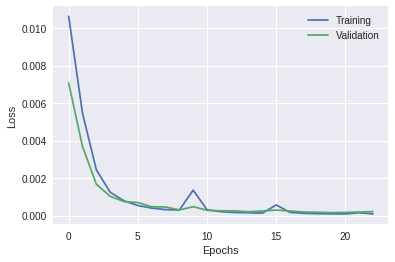

Test loss:  0.000298090502810873


In [75]:
#plot learning history
plot_history(history)

# Final evaluation of the model
test_generator = DataGenerator(test, dim=img_shape, batch_size=16)
scores = model.evaluate_generator(test_generator, verbose=0)
print("Test loss: ", scores)
# print("Test accuracy: %.2f%%" % (scores[2]*100))

##Plotting predictions on a separate demo video
(none of these frames have been seen by the network)

Calculating predictions on demo video: [==================================================>]

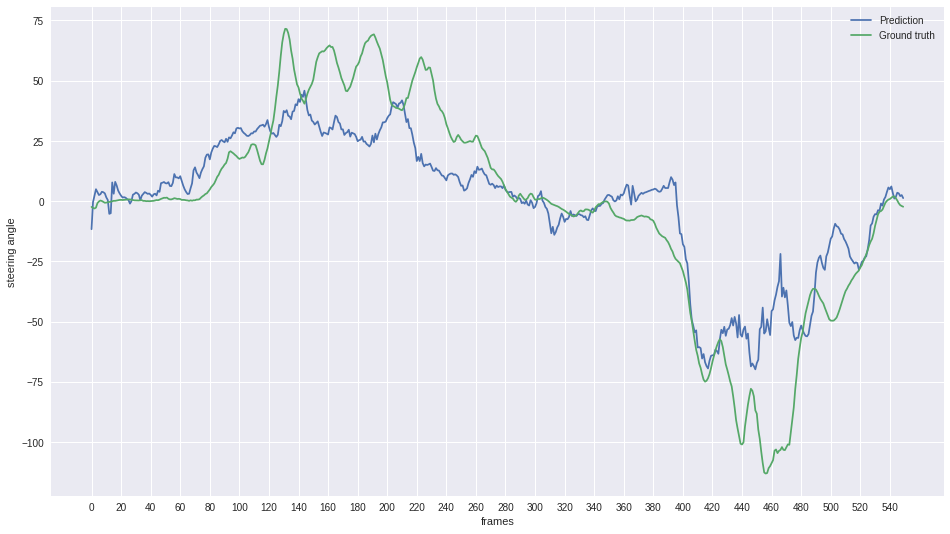

In [76]:
predictions = []
truth = []

metafile = open("dataset/metainfos/demo.txt")
counter = 0

# output = os.popen("ls dataset/demo_frames | wc -l").read()
# videolength = int(output.replace("\n", ""))

videolength = 550

for i in range(videolength):
    values = metafile.readline().split(";")
    if len(values) < 2:
        break

    truth.append(float(values[0]))
    
    img = np.array(img_to_array(load_img('dataset/demo_frames/frame_' + str(i) + '.png'))/255.0, copy=False, ndmin=4)
    predictions.append(scaler.inverse_transform(model.predict(img))[0][0])
    
    counter += 1
    
    
    cnt = int(counter/videolength*50)
    sys.stdout.write('\r'+ "Calculating predictions on demo video: [" + "="*cnt + ">" + " "*(50-cnt-1) + "]")


metafile.close()

    
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.plot(predictions)
plt.plot(truth)
plt.legend(['Prediction', 'Ground truth'])
plt.xticks(np.arange(0, videolength, step=20))
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.show()

##Visualizing the activations


In [0]:
from keras import applications

model = load_model('model/weights/pilotnet_relu_sigmoid_batchnorm_nadam_00016.hdf5')
# input_img = np.array(img_to_array(load_img('dataset/demo_frames/frame_80.png'))/255.0, copy=False, ndmin=4)
input_img = model.input



In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_names = ["conv2d_53","conv2d_54","conv2d_55","conv2d_56","conv2d_57"]
# layer_names = ["conv_1","conv_2","conv_3","conv_4","conv_5"]

In [0]:
#@title Visualizer class { form-width: "20%", display-mode: "form" }
#https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html
import numpy as np
from keras import backend as K

class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        
    def find_n_feature_map(self,layer_name,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,iterate,input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 
        ## I played with this step value but the final image looks to be robust
        step = 500 

        
        
        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return(input_img_data,loss_values)

    def create_iterate(self,input_img, layer_output,filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,input_img,layer_names,layer_dict, max_nfmap,
                    picorig=False,n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,input_img,layer_output,indecies,
                              picorig=False,n_iter=30):
        '''
        indecies : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indecies: # filtermap to visualize
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = np.sort(list(argimage.keys()))


        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()

In [0]:
max_nfmap = 8
input_img = model.layers[0].input
visualizer = VisualizeImageMaximizeFmap(pic_shape = (73,200,3))
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap,
                                    n_iter=10)


find images that maximize feature maps


In [0]:
visualizer.plot_images_wrapper(argimage, n_row = 1, scale = 10)

##Another method for visualization

In [0]:
model = load_model('model/weights/pilotnet_swish_sigmoid_noBatchnorm_nadam_00015.hdf5')
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
input_img = np.array(img_to_array(load_img('dataset/demo_frames/frame_144.png'))/255.0, copy=False, ndmin=4)
activations = activation_model.predict(input_img)
 

In [0]:
#https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    plt.axis('off')
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*5))
    
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            
            activation_index += 1
    
    
    

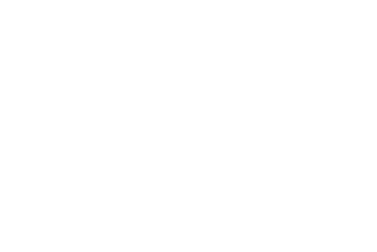

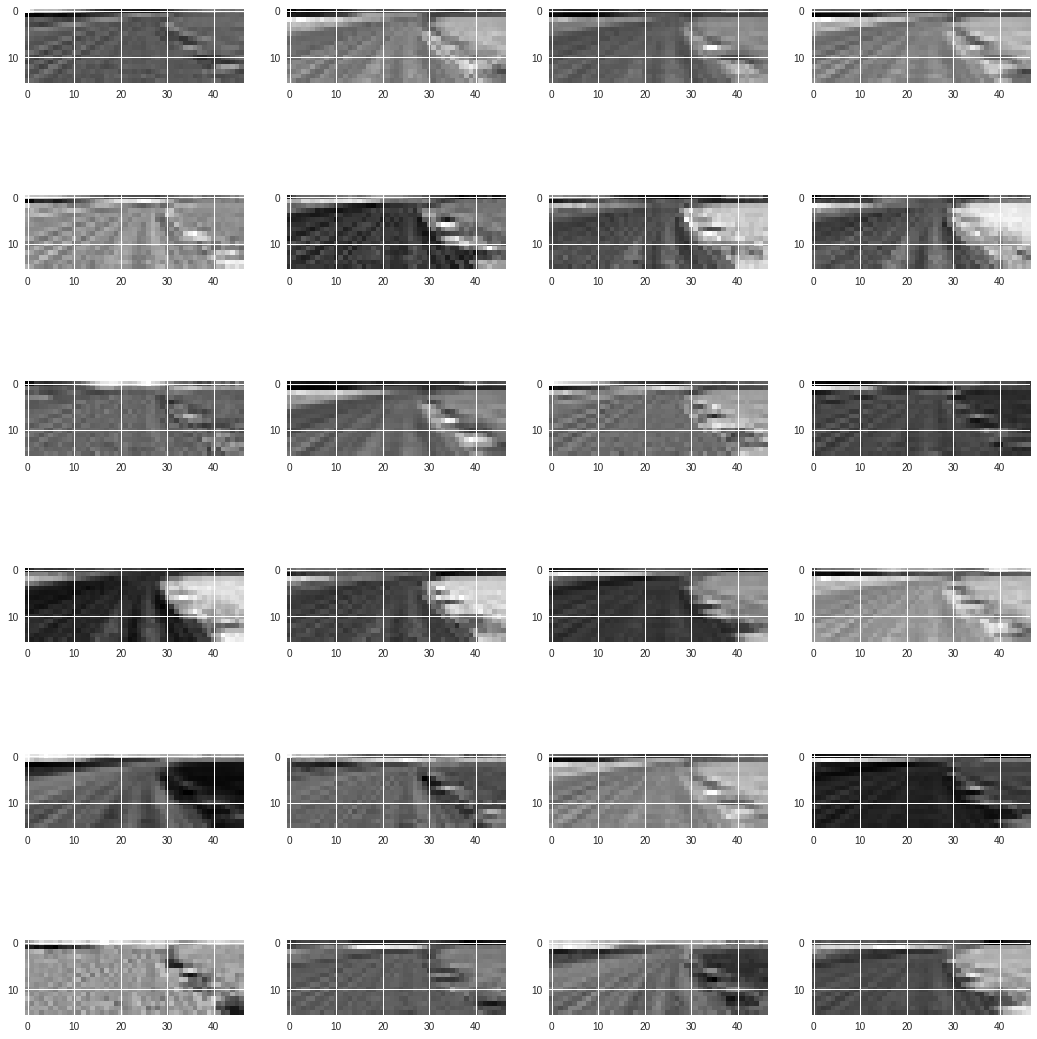

In [79]:
display_activation(activations, 4, 6, 1)


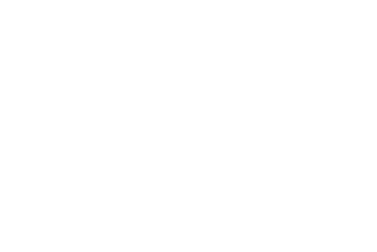

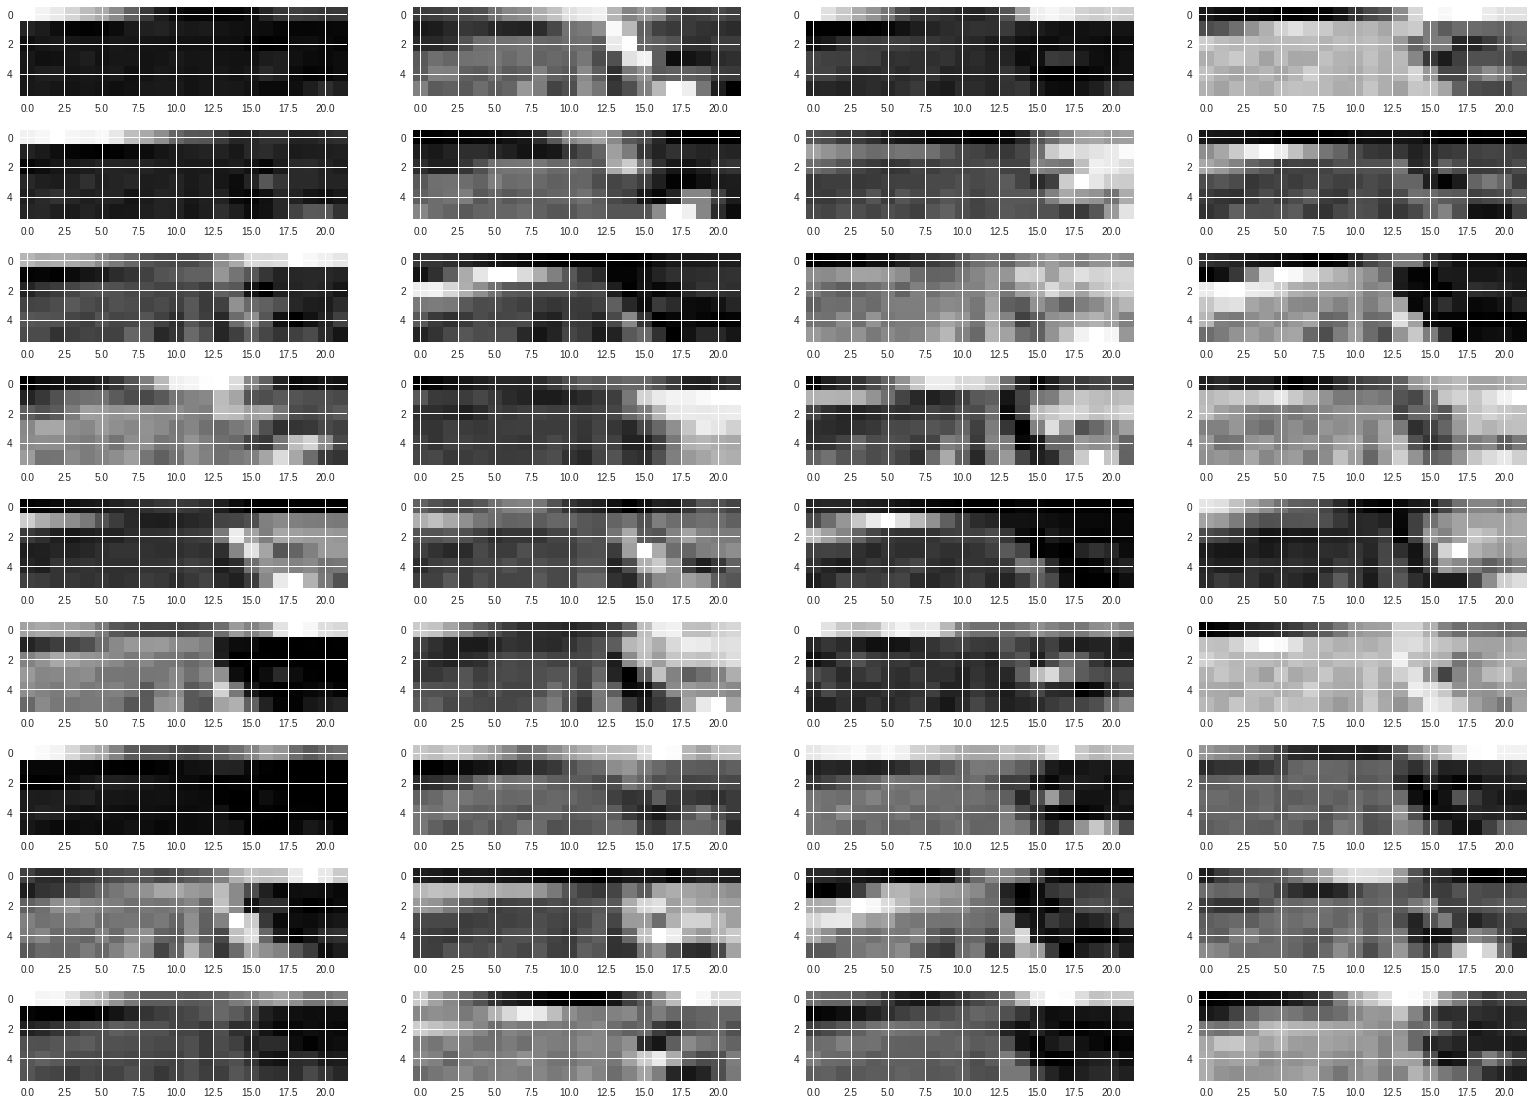

In [80]:
display_activation(activations, 4, 9, 2)

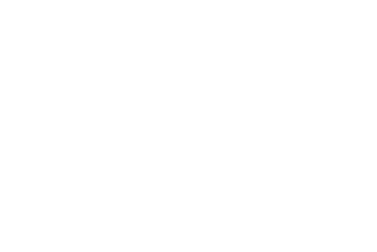

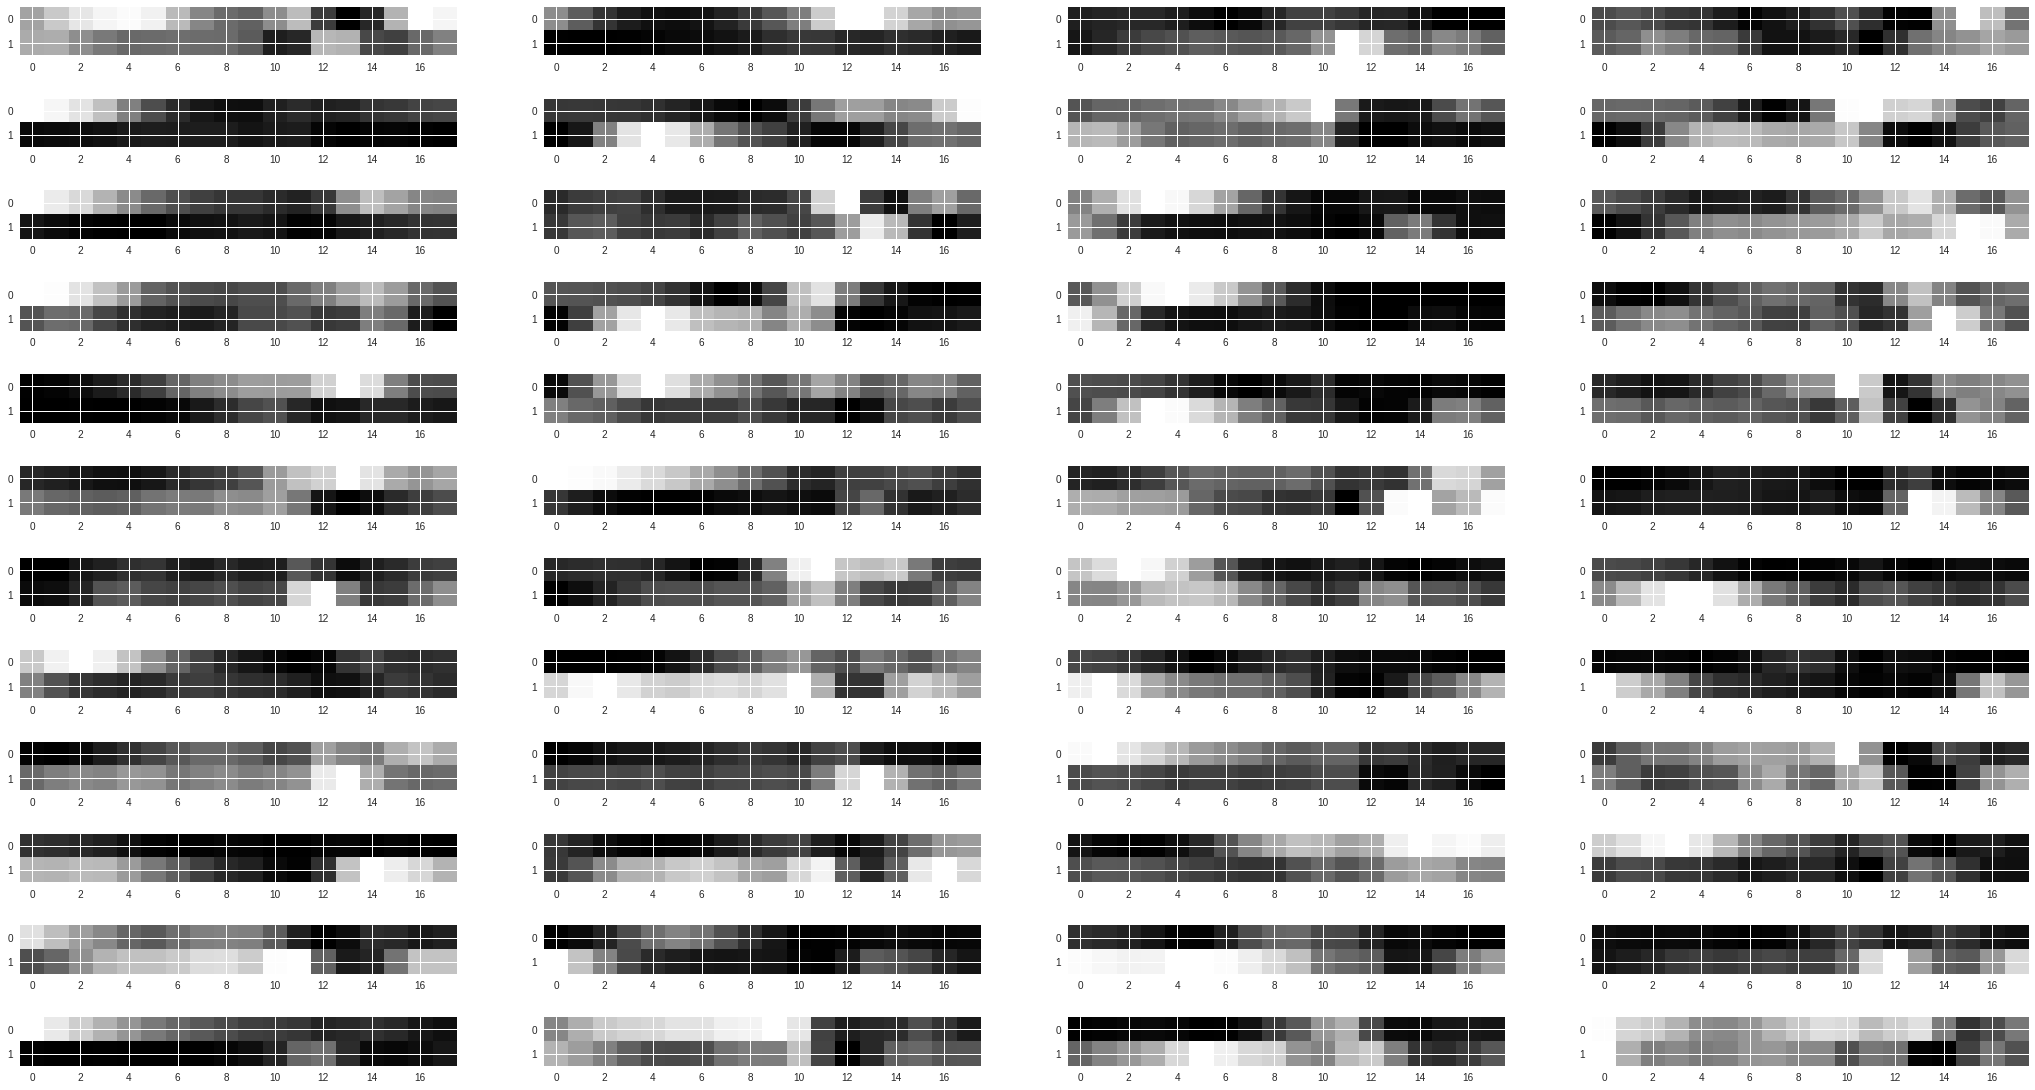

In [81]:
display_activation(activations, 4, 12, 4)

In [0]:
display_activation(activations, 4, 16, 6)